In [1]:
import os
from glob import glob
from xorca.lib import load_xorca_dataset
import xgcm
from matplotlib import pyplot as plt
import numpy as np
from cmocean import cm
from matplotlib import colors
import cartopy.crs as ccrs
os.environ['CARTOPY_USER_BACKGROUNDS'] = '/home/shkifmjr/cartopy_images/'
import xesmf as xe
import xarray as xr
import pandas as pd

import warnings
warnings.simplefilter('ignore')
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

#### Define paths to data, masks, and background image

In [2]:
in_path = '/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP03/OUT/'
mask_path = '/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/'
mesh_base = [mask_path + 'mesh_mask.nc']
mesh_nest = [mask_path + '1_mesh_mask.nc']
img = plt.imread('/home/shkifmjr/cartopy_images/BlueMarble_TOPO_010_FEB.png')

The variables from MOPS are not included in `xorca` by default, so they have to be added (only necessary if we want to plot some of them)

In [3]:
# define additional variables for xorca
mops_vars = {'O2': {'dims': ['t', 'z_c', 'y_c', 'x_c']}, 'PO4': {'dims': ['t', 'z_c', 'y_c', 'x_c']},
             'NO3': {'dims': ['t', 'z_c', 'y_c', 'x_c']}, 'DIC': {'dims': ['t', 'z_c', 'y_c', 'x_c']},
             'DICP': {'dims': ['t', 'z_c', 'y_c', 'x_c']}, 'ALK': {'dims': ['t', 'z_c', 'y_c', 'x_c']},
             'idealpo4': {'dims': ['t', 'z_c', 'y_c', 'x_c']}, 'CFC12': {'dims': ['t', 'z_c', 'y_c', 'x_c']},
             'SF6': {'dims': ['t', 'z_c', 'y_c', 'x_c']}, 'co2flux': {'dims': ['t', 'y_c', 'x_c']},
             'co2flux_pre': {'dims': ['t', 'y_c', 'x_c']}, 'ph': {'dims': ['t', 'y_c', 'x_c']},
             'ph_pre': {'dims': ['t', 'y_c', 'x_c']}, 'fco2': {'dims': ['t', 'y_c', 'x_c']},
             'fco2_pre': {'dims': ['t', 'y_c', 'x_c']}}

#### Load the data from nest and host grid with `load_xorca_dataset`
Note that we need only need to load `5d` and `1m` data because the sea ice is not written at `5d` output resolution...

In [4]:
data_base_5d = load_xorca_dataset(data_files=sorted(glob(in_path + 'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP03'
                                                         + '_5d_19810101_19811231_[gimt]*.nc')),
                                  aux_files=mesh_base,
                                  update_orca_variables=mops_vars,
                                  model_config='GLOBAL',
                                  input_ds_chunks={"time_counter": 73, "t": 73, "z": 1, "deptht": 1, "depthu": 1, "depthv": 1, "depthw": 1},
                                  target_ds_chunks = {"t": 73, "z_c": 1, "z_l": 1})

In [5]:
data_base_1m = load_xorca_dataset(data_files=sorted(glob(in_path + 'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP03'
                                                         + '_1m_19810101_19811231_[gimt]*.nc')),
                                  aux_files=mesh_base,
                                  update_orca_variables=mops_vars,
                                  model_config='GLOBAL',
                                  input_ds_chunks={"time_counter": 120, "t": 120, "z": 1, "deptht": 1, "depthu": 1, "depthv": 1, "depthw": 1},
                                  target_ds_chunks = {"t": 120, "z_c": 1, "z_l": 1})

In [6]:
data_nest_5d = load_xorca_dataset(data_files=sorted(glob(in_path + '1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP03'
                                                         + '_5d_19810101_19811231_[gimt]*.nc')),
                                  aux_files=mesh_nest,
                                  update_orca_variables=mops_vars,
                                  model_config='NEST',
                                  input_ds_chunks={"time_counter": 73, "t": 73, "z": 1, "deptht": 1, "depthu": 1, "depthv": 1, "depthw": 1},
                                  target_ds_chunks = {"t": 73, "z_c": 1, "z_l": 1})

In [7]:
data_nest_1m = load_xorca_dataset(data_files=sorted(glob(in_path + '1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP03'
                                                         + '_1m_19810101_19811231_[gimt]*.nc')),
                                  aux_files=mesh_nest,
                                  update_orca_variables=mops_vars,
                                  model_config='NEST',
                                  input_ds_chunks={"time_counter": 120, "t": 120, "z": 1, "deptht": 1, "depthu": 1, "depthv": 1, "depthw": 1},
                                  target_ds_chunks = {"t": 120, "z_c": 1, "z_l": 1})

Defining the metrics to be used by `xgcm` is not really necessary because we do not use any weights for computing the speed later. It's included here for completeness of the regular data loading etc.. (load modules -> define paths -> define additional variable -> load data -> define metrics -> define grids)

In [8]:
# define metrics for xgcm
at_base, au_base = data_base_1m['e1t'] * data_base_1m['e2t'], data_base_1m['e1u'] * data_base_1m['e2u']
av_base, af_base = data_base_1m['e1v'] * data_base_1m['e2v'], data_base_1m['e1f'] * data_base_1m['e2f']

data_base_5d = data_base_5d.update({'at': at_base, 'au': au_base, 'av': av_base, 'af': af_base})
data_base_5d = data_base_5d.set_coords(['at', 'au', 'av', 'af'])
data_base_1m = data_base_1m.update({'at': at_base, 'au': au_base, 'av': av_base, 'af': af_base})
data_base_1m = data_base_1m.set_coords(['at', 'au', 'av', 'af'])

at_nest, au_nest = data_nest_1m['e1t'] * data_nest_1m['e2t'], data_nest_1m['e1u'] * data_nest_1m['e2u']
av_nest, af_nest = data_nest_1m['e1v'] * data_nest_1m['e2v'], data_nest_1m['e1f'] * data_nest_1m['e2f']

data_nest_5d = data_nest_5d.update({'at': at_nest, 'au': au_nest, 'av': av_nest, 'af': af_nest})
data_nest_5d = data_nest_5d.set_coords(['at', 'au', 'av', 'af'])
data_nest_1m = data_nest_1m.update({'at': at_nest, 'au': au_nest, 'av': av_nest, 'af': af_nest})
data_nest_1m = data_nest_1m.set_coords(['at', 'au', 'av', 'af'])

metrics = {('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
           ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
           ('X', 'Y'): ['at', 'au', 'av', 'af']} # Areas

#### Define the grid with `xgcm`

In [9]:
grid_base = xgcm.Grid(data_base_1m.isel(z_c=9, z_l=9), metrics=metrics)
grid_nest = xgcm.Grid(data_nest_1m.isel(z_c=9, z_l=9), metrics=metrics)

#### extract the CO2 flux

In [10]:
co2flux_base= data_base_5d['co2flux_pre'].isel(y_c=slice(1,-10))
co2flux_nest= data_nest_5d['co2flux_pre']

co2flux_base.values = co2flux_base.where(co2flux_base != 0, other=np.nan).values
co2flux_nest.values = co2flux_nest.where(co2flux_nest != 0, other=np.nan).values

#### Now we interpolate the sea-ice to a `5d`-time axis so we can plot it along with the CO2 flux
Additionally we load the ice data into memory with `.compute()` so the plotting is faster  
In the y-direction, we exclude the first and the last 10 grid cells because otherwise there are projection errors... To circumvent these errors and still plot the whole data, one has to interpolate before plotting (see the `nice_plots.ipynb`)

In [11]:
ice_base_all = data_base_1m['ileadfra'].isel(y_c=slice(1,-10)).interp(t=pd.date_range('1981-01-03', '1981-12-31', periods=73)).compute()
ice_nest_all = data_nest_1m['ileadfra'].interp(t=pd.date_range('1981-01-03', '1981-12-31', periods=73)).compute()

We also load the speed data into memory, which takes some time, but saves us a lot of time during the plotting

Same for the longitude and latitude data

In [12]:
lon_base = data_base_1m['llon_cc'].isel(y_c=slice(1,-10)).compute()
lat_base = data_base_1m['llat_cc'].isel(y_c=slice(1,-10)).compute()
lon_nest = data_nest_1m['llon_cc'].compute()
lat_nest = data_nest_1m['llat_cc'].compute()  

#### We need to define a new class for the projection to change the `threshold` value in order to draw smooth lines with `plot`

In [13]:
class LowerThresholdNearsidePerspective(ccrs.NearsidePerspective):

    @property
    def threshold(self):
        return 1000

### Now the plot

(-3000000.0, 3200000.0)

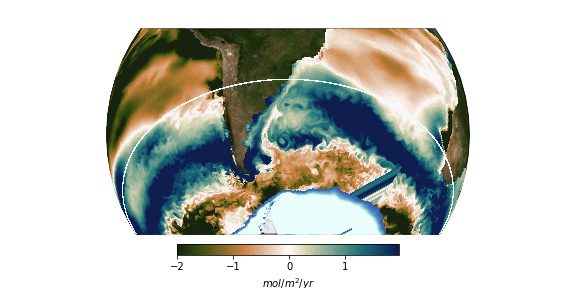

In [15]:
plt.figure(figsize=(8,4))
ax = plt.gca()
   
# define the levels for the colormap and construct a norm out of that for `pcolormesh`
#levs = np.hstack((np.arange(0, 0.3, 0.02), np.arange(0.3, 0.8, 0.1)))
levs = np.hstack((np.arange(-2, 2, 0.05)))
norm = colors.BoundaryNorm(boundaries=levs, ncolors=256)  

# we loop over all the time steps and save one image for each, so we can later combine them for an animation
#for t in np.arange(36, 37):  #730
    #plt.clf()
    
    # extract data to plot at the current time step
co2f_base = co2flux_base.isel(t=36)
ice_base = ice_base_all.isel(t=36)
co2f_nest = co2flux_nest.isel(t=36)
ice_nest = ice_nest_all.isel(t=36)
    
    # define the central longitude of the plot
    # we let that change with `t`, so that the globe then rotates in the animation
   # central_lon = np.linspace(130.0, 370.0, 730)[t]
   # central_lon = np.linspace(-30.0, 370.0, 730)[t]
    #if central_lon > 180.:
    #    central_lon = central_lon - 360.
    
    # define the axes with the projection
    
ax = plt.axes(projection=LowerThresholdNearsidePerspective(central_longitude=-50, 
                                                      central_latitude=-45, satellite_height=36000000))
 
    # plot the background image, setting `regrid_shape` to higher values, improves the plotted resolution of the background image
#ax.imshow(img, origin='upper', transform=ccrs.PlateCarree(), interpolation='bilinear', regrid_shape=200) # low resolution background
ax.imshow(img, origin='upper', transform=ccrs.PlateCarree(), interpolation='spline36', regrid_shape=1000) # high resolution background
    
    # first plot the ice (for some reason the plot looks weird, when the commands to plot the ice are executed later,
    # note that the ice will still be plotted on top of the ocean currents because we set `zorder`)
    
    
map3 = ax.pcolormesh(lon_base, lat_base, ice_base.where(ice_base > 0.2).squeeze(),
                   cmap=cm.ice, vmin=0, vmax=0.5, alpha=1, transform=ccrs.PlateCarree(), zorder=5)
    
map4 = ax.pcolormesh(lon_nest, lat_nest, ice_nest.where(ice_nest > 0.2).squeeze(),
                       cmap=cm.ice, vmin=0, vmax=0.5, alpha=1, transform=ccrs.PlateCarree(), zorder=6)

# now plot the CO2 flux
map1 = ax.pcolormesh(lon_base, lat_base, co2f_base, 
                         norm=norm, cmap=cm.tarn, vmin=-3, vmax=3, transform=ccrs.PlateCarree(), zorder=3)
    
    
map2 = ax.pcolormesh(data_nest_5d['llon_cc'],
                   data_nest_5d['llat_cc'], co2f_nest, 
                        norm=norm, cmap=cm.tarn, vmin=-3, vmax=3, transform=ccrs.PlateCarree(), zorder=4)


# draw the colorbar and set the labels and ticks
#c = plt.colorbar(map1, pad=0.01, shrink=0.4, orientation='vertical')
c = plt.colorbar(map1, pad=0.04, shrink=0.4, orientation='horizontal')
c.ax.set_xlabel('$mol/m^2/yr$')
c.set_ticks([-3, -2, -1 , 0, 1, 2, 3])
   
    
# reduce the white spaces around the plot and set a title
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.9)
    
# set the latitude limits of the plot. we do that in projection coordinates (m) because there are some problems when using latitude
ax.set_ylim(-3000000, 3200000)
    
    # and finally save the plot
#plt.savefig('/home/shklvn09/python_plots/co2flux/ORION10_co2flux_ice_globe_snapshot.png',
           #format='PNG', dpi=600)


### How to animate
To now make an animation out of these individual plots, we can use `convert`, e.g.
```shell
convert -delay 13 ORION10_speed_ice_globe_*.png -loop 0 test.gif
```
and because gifs are quite large we convert that to a video
```shell
ffmpeg -i test.gif -movflags faststart -pix_fmt yuv420p -vf "crop=trunc(iw/2)*2:trunc(ih/2)*2" test.mp4
```